In [1]:
!pip install numpy pandas matplotlib scikit-learn keras tensorflow yfinance



[*********************100%%**********************]  1 of 1 completed
Epoch 1/100
196/196 - 3s - loss: 0.0393 - 3s/epoch - 17ms/step
Epoch 2/100
196/196 - 1s - loss: 0.0061 - 537ms/epoch - 3ms/step
Epoch 3/100
196/196 - 1s - loss: 0.0052 - 569ms/epoch - 3ms/step
Epoch 4/100
196/196 - 1s - loss: 0.0052 - 644ms/epoch - 3ms/step
Epoch 5/100
196/196 - 1s - loss: 0.0048 - 604ms/epoch - 3ms/step
Epoch 6/100
196/196 - 1s - loss: 0.0045 - 541ms/epoch - 3ms/step
Epoch 7/100
196/196 - 1s - loss: 0.0047 - 581ms/epoch - 3ms/step
Epoch 8/100
196/196 - 1s - loss: 0.0047 - 574ms/epoch - 3ms/step
Epoch 9/100
196/196 - 1s - loss: 0.0049 - 571ms/epoch - 3ms/step
Epoch 10/100
196/196 - 1s - loss: 0.0044 - 542ms/epoch - 3ms/step
Epoch 11/100
196/196 - 1s - loss: 0.0045 - 522ms/epoch - 3ms/step
Epoch 12/100
196/196 - 1s - loss: 0.0043 - 520ms/epoch - 3ms/step
Epoch 13/100
196/196 - 1s - loss: 0.0042 - 521ms/epoch - 3ms/step
Epoch 14/100
196/196 - 1s - loss: 0.0045 - 535ms/epoch - 3ms/step
Epoch 15/100
196/1

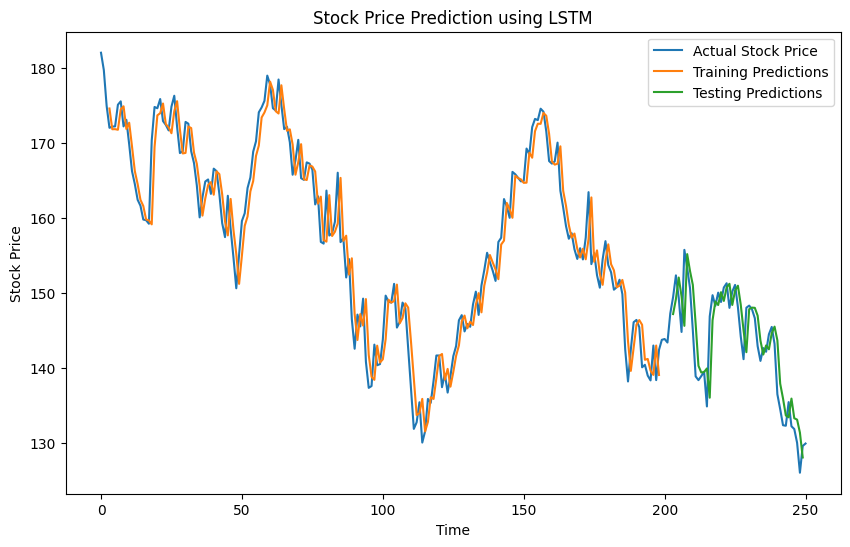

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import yfinance as yf

# Fetch stock data
symbol = 'AAPL'  # Replace with your desired stock symbol
start_date = '2022-01-01'
end_date = '2023-01-01'

stock_data = yf.download(symbol, start=start_date, end=end_date)

# Use 'Close' prices for prediction
dataset = stock_data['Close'].values.reshape(-1, 1)

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# Split the dataset into training and testing sets
train_size = int(len(dataset_scaled) * 0.8)
train, test = dataset_scaled[0:train_size, :], dataset_scaled[train_size:len(dataset_scaled), :]

# Create a function to prepare the dataset for LSTM
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(1, look_back)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Inverse transform the predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY_actual = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_actual = scaler.inverse_transform([testY])

# Plot the predictions
trainPredictPlot = np.empty_like(dataset_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset_scaled)-1, :] = testPredict

plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(dataset_scaled), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Training Predictions')
plt.plot(testPredictPlot, label='Testing Predictions')
plt.title('Stock Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
